# 12.09周报

主要写对数据和引擎的熟悉进度，做了什么，下周准备做什么，也可以是回测中困扰你或者有意思的地方

## 进度

本周学习了课件中的内容，对其中常用的一些策略、概念和“行话”等进行了了解，对课件中涵盖的策略类型、引擎的基本用法和仓位与风险管理有了一定的认识和思考。  
尤其对课件中多信号策略在十月份的回测绩效（年化收益竟高达2w个百分点）很感兴趣，实践的内容也围绕它展开，尝试更改参数、更改回测时间区间、添加其他策略如止盈止损等，观察回测绩效变化

In [51]:

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta

########################################################################
# 策略继承CtaTemplate
class multi_signal_Strategy(CtaTemplate):
    """多信号加仓Demo"""
    className = 'multi_signal_Strategy'
    author = 'erwin'
    
    # 策略参数
    barPeriod = 200
    fastWindow = 60     # 快速均线参数
    slowWindow = 120     # 慢速均线参数
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['barPeriod',]  
    nPos = 0
    fixsize = 100
    transactionPrice = {}
    Ratio = 0.02
    signal_1 = 0
    signal_2 = 0
    signal_3 = 0
    signal = 0
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        
        # 生成Bar数组
        self.setArrayManagerSize(self.barPeriod)
        self.transactionPrice = {s: 0 for s in self.symbolList}

        self.mail("chushihuaaaaaaaaaaaaaaaaaaaaaaaaa")
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        # 多信号加仓模块，多空相反______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 2):    # 持有多头仓位并且加仓次数不超过2次(共三个信号，允许加2次仓)
            if self.signal_1 < 0 or self.signal_2 < 0 or self.signal_3 < 0:   # 持有多仓情况下有一个信号转换为空头信号，则清仓出场
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG']) # 全部头寸出场
            elif self.nPos == 0 and self.signal == 2 :   # 第一次开仓是有一个信号满足，当另一个信号满足多头信号，则加仓
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
            elif self.nPos == 1 and self.signal == 3 :   # 建立在第一次加仓的基础上，再有信号满足多头信号，继续加仓
                self.buy(symbol,bar.close*1.02,self.fixsize)  # 加仓数量固定fixsize
                
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 2):    
            if self.signal_1 > 0 or self.signal_2 > 0 or self.signal_3 > 0:   #
                    self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT']) 
            elif self.nPos == 0 and self.signal == -2 :   # 计算盈利比例
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
            elif self.nPos == 1 and self.signal == -3 :
                self.short(symbol,bar.close*0.98,self.fixsize)  # 加仓数量固定fixsize
                
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am15 = self.getArrayManager(symbol, "15m")

        if not am15.inited:
            return
        
        # 计算策略需要的信号，共三个信号分别是MACD,rsi,动量指标-------------------------------------------------
        diff,dea,hist = ta.MACD(am15.close)
        
        if diff[-1]<0 and dea[-1]<0 and diff[-2]<dea[-2] and diff[-1]>dea[-1]:  
            self.signal_1 = 1
        elif diff[-1]>0 and dea[-2]>0 and diff[-2]>dea[-2] and diff[-1]<dea[-1]:
            self.signal_1 = -1
        else:
            self.signal_1 = 0
        
        rsi = ta.RSI(am15.close)
        
        if rsi[-2]<38 and rsi[-1]>38:
            self.signal_2 = 1
        elif rsi[-2]>68 and rsi[-1]<68:
            self.signal_2 = -1
        else:
            self.signal_2 = 0    
        
        movement = (am15.close[-1] - am15.close[-10])/am15.close[-10]
        
        if movement < -0.015:
            self.signal_3 = 1
        elif movement > 0.015:
            self.signal_3 = -1
        else:
            self.signal_3 = 0

        #将三个信号加和
        self.signal = self.signal_1 + self.signal_2 + self.signal_3
        
        # 构建进出场逻辑-------------------------------------------------
        # 如果3个都不是空头信号，并且有一个信号满足多头信号，则开多仓
        if self.signal_1 >= 0 and self.signal_2 >= 0 and self.signal_3 >= 0 and self.signal == 1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize*0.3)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                self.nPos = 0
                self.buy(symbol,bar.close*1.02, self.fixsize*0.3)

        # 如果3个都不是多头信号，并且有一个信号满足空头信号，则开空仓
        elif self.signal_1 <= 0 and self.signal_2 <= 0 and self.signal_3 <= 0 and self.signal == -1:
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.nPos = 0
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
        
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(u'出现未知订单，需要策略师外部干预,ID:%s, symbol:%s,direction:%s,offset:%s'% (order.vtOrderID, order.vtSymbol, order.direction, order.offset))
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        self.transactionPrice[symbol] = trade.price
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_15Min_bar函数functools.partial(<function multi_signal_Strategy.on15MinBar at 0x000002001DC66BF8>, <__main__.multi_signal_Strategy object at 0x00000200032E5780>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function multi_signal_Strategy.onBar at 0x000002001DC66400>, <__main__.multi_signal_Strategy object at 0x00000200032E5780>)
2018-12-08 13:50:56.947524	开始回测
2018-12-08 13:50:56.948522	策略初始化
2018-12-08 13:50:56.950518	载入历史数据。数据范围:[20180607 04:00,20180615 12:00)
2018-12-08 13:50:57.411512	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 13:50:57.416509	载入完成，数据量：12000
2018-12-08 13:50:57.417509	策略初始化完成
2018-12-08 13:50:57.417509	策略启动完成
2018-12-08 13:50:57.417509	开始回放回测数据,回测范围:[20180615 12:00,20181128 16:00)
2018-12-08 13:50:57.440493	载入历史数据。数据范围:[20180615 12:00,20181128 16:00)
2018-12-08 13:51:07.339246	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-08 13:51:07.409233	载入完成，数据量：2

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180613100000 , 20180615114500]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180615120100
[INFO] 品种EOSUSDT:binance开始生成15mK线数据,时间起点为:20180615120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 11.255, 'high': 11.2788, 'low': 11.1572, 'close': 11.1709, 'date': '20180615', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 15, 12, 0), 'volume': 30514.700000000004, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史15mK线更新，范围为:[20180613101500 , 20180615120000]
[INFO] 品种EOSUSDT:binance的15mK线准备就绪,当前K线时间为20180615120000
2018-12-08 13:51:20.481630	数据回放结束ss: 100%    
2018-12-08 13:51:20.482628	计算按日统计结果
2018-12-08 13:51:20.511613	------------------------------
2018-12-08 13:51:20.512612	首个交易日：	2018-06-15 00:00:00
2018-12-08 13:51:20.512612	最后交易日：	2018-11-28 00:00:00
2018-12-08 13:51:20.513609	总交易日：	167
2018-12-08 13:51:20.513609	盈利交易日	92
2018-12-08 13:51:2

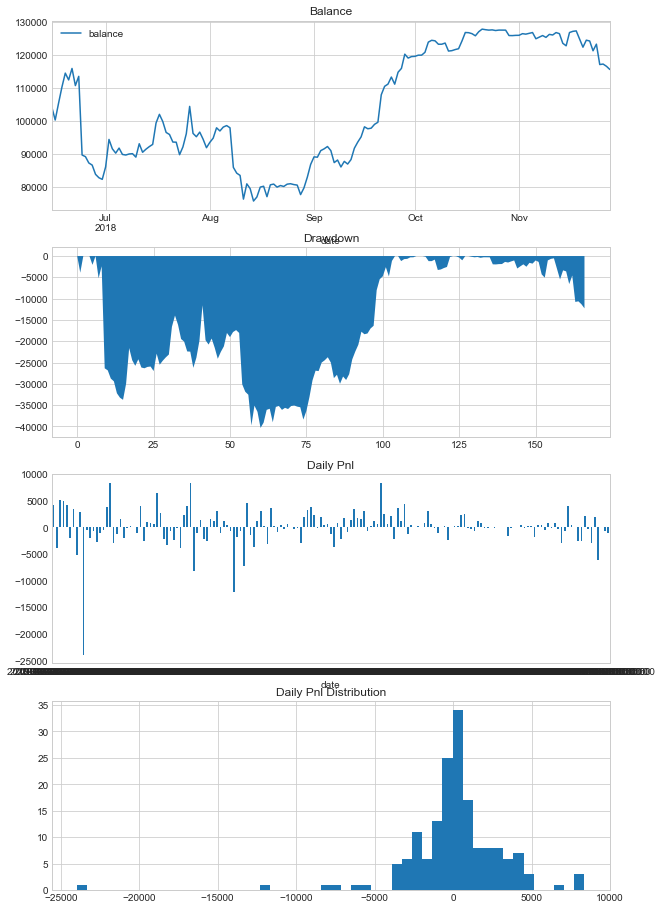

2018-12-08 13:51:22.918225	计算回测结果
2018-12-08 13:51:23.042154	------------------------------
2018-12-08 13:51:23.042154	第一笔交易：	2018-06-15 13:15:00
2018-12-08 13:51:23.043164	最后一笔交易：	2018-11-28 15:58:00
2018-12-08 13:51:23.043164	总交易次数：	1,788
2018-12-08 13:51:23.043164	总盈亏：	-11,856.22
2018-12-08 13:51:23.043164	最大回撤: 	-104,225.0
2018-12-08 13:51:23.043164	平均每笔盈利：	-6.63
2018-12-08 13:51:23.043164	平均每笔滑点：	0.0
2018-12-08 13:51:23.043164	平均每笔佣金：	29.64
2018-12-08 13:51:23.043164	胜率		59.62%
2018-12-08 13:51:23.044152	盈利交易平均值	592.05
2018-12-08 13:51:23.044152	亏损交易平均值	-890.56
2018-12-08 13:51:23.044152	盈亏比：	0.66


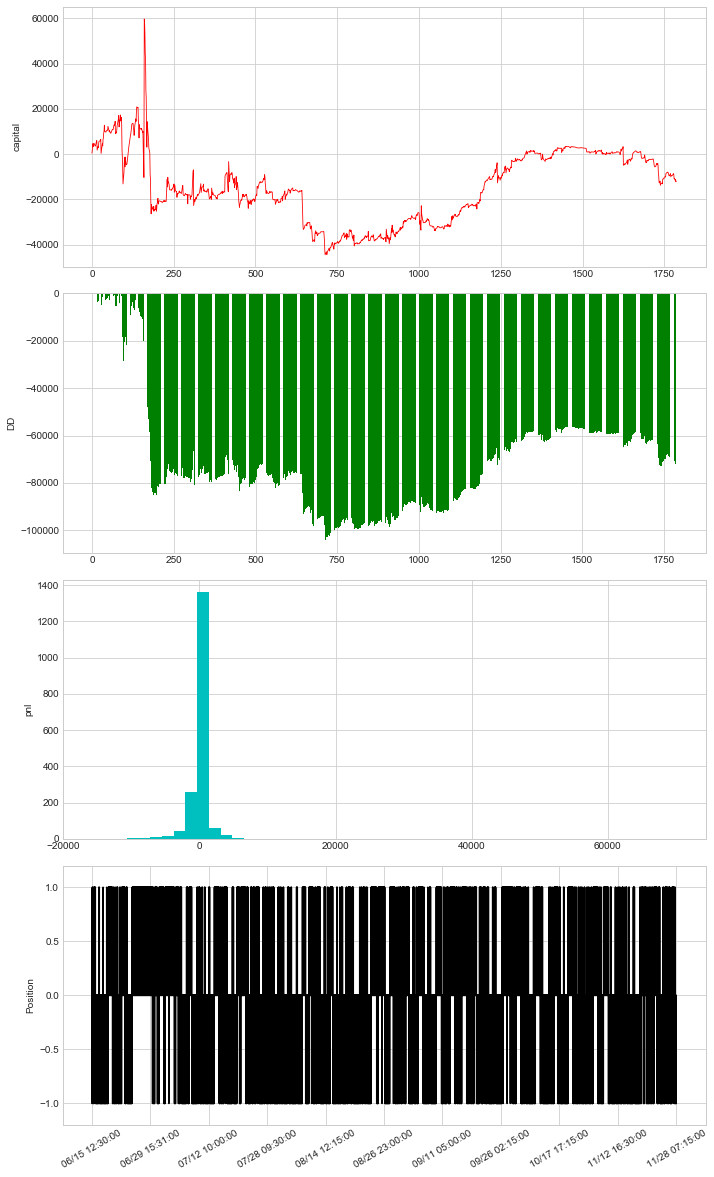

2018-12-08 13:51:28.479432	计算按日统计结果


In [52]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase('VnTrader_1Min_Db')
    engine.setStartDate(startDate, initHours=200)
    engine.setEndDate(endDate)
    engine.setSize(size)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)
    #engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(multi_signal_Strategy, {'symbolList': ['EOSUSDT:binance']},
                       '20180615 12:00', '20181128 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('BBandMa5MinStrategyReport.xlsx')

### 实验现象和结论

1.将三个信号之一的RSI的参数进行修改，周期设置为14天，两个多空阈值设定为30和70（维基百科中的推荐值），其他不改变。在2月到11月期间原RSI的回测绩效为（年化收益：	40,417.65%总盈亏：	50,690,468.66最大回撤: 	-43,743,273.23百分比最大回撤: -1,657.66%Sharpe Ratio：	1.0最大回撤: 	-168,697,983.75胜率		56.37%盈亏比：	0.78）；新RSI下的绩效为（年化收益：	17,890.39%总盈亏：	22,437,530.61最大回撤: 	-35,895,261.04百分比最大回撤: -649.54%Sharpe Ratio：	0.64最大回撤: 	-48,066,291.69胜率		54.64%盈亏比：	0.81）。但从最大回撤来看，两者都有较大的风险，盈亏比也都不够高。总的来讲，原RSI的参数有更好的绩效。  
  
2.双均线与多信号结合的加仓策略与单独的多信号加仓策略相比，回测结果未见明显变化。  
  
3.在多信号策略中加入策略后，十月份btc回测结果劣化（年化收益：	1,441.7%总盈亏：	186,219.83最大回撤: 	-349,264.95百分比最大回撤: -116.58%Sharpe Ratio：	-0.72最大回撤: 	-388,119.87胜率		33.33%盈亏比：	2.39），而单纯的多信号策略绩效为（年化收益：	26,496.41%总盈亏：	3,422,453.21最大回撤: 	-1,355,557.48百分比最大回撤: -56.9%Sharpe Ratio：	1.78最大回撤: 	-2,837,532.22胜率:		42.08%盈亏比：	1.52）。  
  
4.在多信号策略中加入止盈止损策略后，2至11月份btc回测结果几乎反转了（年化收益：	-19,372.58%总盈亏：	-24,296,446.69最大回撤: 	-42,749,785.17百分比最大回撤: -574.85%Sharpe Ratio：	-0.57最大回撤: 	-68,689,640.59胜率		53.65%盈亏比：	0.8），而没有添加止盈止损策略之前的回测绩效是（年化收益：	17,890.39%总盈亏：	22,437,530.61最大回撤: 	-35,895,261.04百分比最大回撤: -649.54%Sharpe Ratio：	0.64最大回撤: 	-48,066,291.69胜率		54.64%盈亏比：	0.81）。  
  
5.在6月15日至11月28日期间的EOS回测中，原RSI的绩效为：（年化收益：	22.46%总盈亏：	15,629.47最大回撤: 	-40,352.51百分比最大回撤: -34.8%Sharpe Ratio：	0.29最大回撤: 	-104,225.0胜率		59.62%盈亏比：	0.66）；新RSI绩效为（年化收益：	4.25%总盈亏：	2,959.33最大回撤: 	-48,354.27百分比最大回撤: -41.97%Sharpe Ratio：	-0.01最大回撤: 	-111,672.34胜率		58.66%盈亏比：	0.68）。依然是原来的RSI表象更好，而且好的多。  
  
总结：上述实验主要对比了新老RSI对回测绩效的影响和向多信号策略中添加其他策略在不同回测时间、不用市场情况下的影响，通过对结果的观察可以发现，原RSI的表现更为出色；向多信号策略中添加其他策略往往会带来负面影响；同一策略在不同的时间区间内的绩效很不相同；同一策略在不同币种下的表现有着巨大的差异。  
  
疑惑：为什么同样的策略在btc和eos市场的年化收益会相差三四个数量级？

## 笔记

### 1. CTA策略类型

1.高低价通道（唐奇安通道规则，Donchian channel）为：当最高价高于前X个K的最大最高价时，做多；当最低价低于前X个K的最小最低价时，做空。如果你想对往后回溯多少K进行优化，你会发现在不同市场会得到不同的结果，甚至同一市场不同时期最优值也是不同的。但是一般默认值为20。为什么默认的X是20呢？Donchian在开发唐奇安通道的期间，碰巧阅读到整形外科医生Maxwel Maltz博士在1960年所作的“心理控制论”（这本书在1989年被重新发现）。Maltz博士称在整形外科手术过程中，患者最少需要21日来看到自己的新的容颜。而很多我观察到的现象都显示了其最起码需要21日来使得新事物代替旧事物。这一事实震惊了Donchian，21个自然日就等于15个交易日！当绝大多数交易者都在认为趋势可能已经变化时（他们认为看到了市场的新颜），主要趋势却已做好了继续运行的准备。  

### 2. VNPY的引擎

1.关于self.buy(),self.sell(),self.conver()函数的区别，是否可以理解为：buy是Buy To Open；sell是Sell To Close；cover是Buy To Pay？  
2.策略参数中的手数（lot）通常设置为1，一手是买入或卖出多少呢？比如btc交易中一手是一个btc吗？  
3.（关于引擎的工作原理）回测过程中发送的限价单会确保一定能够被卖出或买到吗？真实交易过程中能得到保证吗？  
4.根据RSI的维基百科词条：“根据威尔德的测量结果，当n=14时，指数最具代表性。他指出当某证券的RSI升至70时，代表该证券已被超买（Overbought），投资者应考虑出售该证券。相反，当证券RSI跌至30时，代表证券被超卖（Oversold），投资者应购入该证券。”  
5.对吊灯止损的补充：  
补充：吊灯止损  
if 现价 < 最高价-3* ATR： 
卖出止损  
else：  
继续持有  

### 3. 仓位与风险管理

1.固定价位止盈止损中固定点数和固定百分比的代码几乎一致，是固定百分比的逻辑。固定点数的代码似乎没有体现出“设置当前价格触发成交价‘加减’固定点数的止损止盈时执行平仓”的逻辑，是代码写错了还是这两种止盈止损方式本就一致？  
2.固定价位止盈止损中固定点数的代码中持有空头的平仓条件中  
    `if (bar.close>shortStop) or (bar.close<takeProfitPoint):`  
    为什么是takeProfitPoint而不是shortProfit？  
3.为什么要在止盈止损之外设置平保？  
4.trailingStopLoss的实例中，maTrend变量在on60MinBar中更新，而这个指标在on15MinBar中会用到，这是否会造成某些on15MinBar的函数中用到的maTrend不是最新的？maTrend的更新可否放在15Min中执行？